In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from prettytable import PrettyTable


url = 'https://prsindia.org/covid-19/cases'

web_content = requests.get(url).content
soup = BeautifulSoup(web_content, 'html.parser')

# remove any newlines and extra spaces from left and right
extract_contents = lambda row: [x.text.replace('\n', '') for x in row]

# find all table rows and data cells within
stats = [] 
all_rows = soup.find_all('tr')

for row in all_rows:
    stat = extract_contents(row.find_all('td')) 
    if len(stat) == 6:
        stats.append(stat)
    
#now convert the data into a pandas dataframe for further processing
new_cols = ["Sr.No", "States/UT","Confirmed","Active","Recovered","Deceased"]
state_data = pd.DataFrame(data = stats, columns = new_cols)
state_data.head()



,Sr.No,States/UT,Confirmed,Active,Recovered,Deceased
0,,India,43079188,19092,42536253,523843
1,1,Andaman and Nicobar Islands,10035,0,9906,129
2,2,Andhra Pradesh,2319687,23,2304934,14730
3,3,Arunachal Pradesh,64495,0,64199,296
4,4,Assam,724213,11,716216,7986


In [29]:
state_data['Confirmed'] = state_data['Confirmed'].map(int)
state_data['Active'] = state_data['Active'].map(int)
state_data['Recovered'] = state_data['Recovered'].map(int)
state_data['Deceased'] = state_data['Deceased'].map(int)


In [33]:
#Pretty Table
table = PrettyTable()
table.field_names = (new_cols)
for i in stats:
    table.add_row(i)
table.add_row(["","Total", 
           sum(state_data['Confirmed']), 
           sum(state_data['Active']),
           sum(state_data['Recovered']),
           sum(state_data['Deceased']),
              ])
print(table)

+-------+------------------------------------------+-----------+--------+-----------+----------+
| Sr.No |                States/UT                 | Confirmed | Active | Recovered | Deceased |
+-------+------------------------------------------+-----------+--------+-----------+----------+
|       |                  India                   |  43079188 | 19092  |  42536253 |  523843  |
|   1   |       Andaman and Nicobar Islands        |   10035   |   0    |    9906   |   129    |
|   2   |              Andhra Pradesh              |  2319687  |   23   |  2304934  |  14730   |
|   3   |            Arunachal Pradesh             |   64495   |   0    |   64199   |   296    |
|   4   |                  Assam                   |   724213  |   11   |   716216  |   7986   |
|   5   |                  Bihar                   |   830562  |   40   |   818266  |  12256   |
|   6   |                Chandigarh                |   92060   |   71   |   90824   |   1165   |
|   7   |               Chhatt

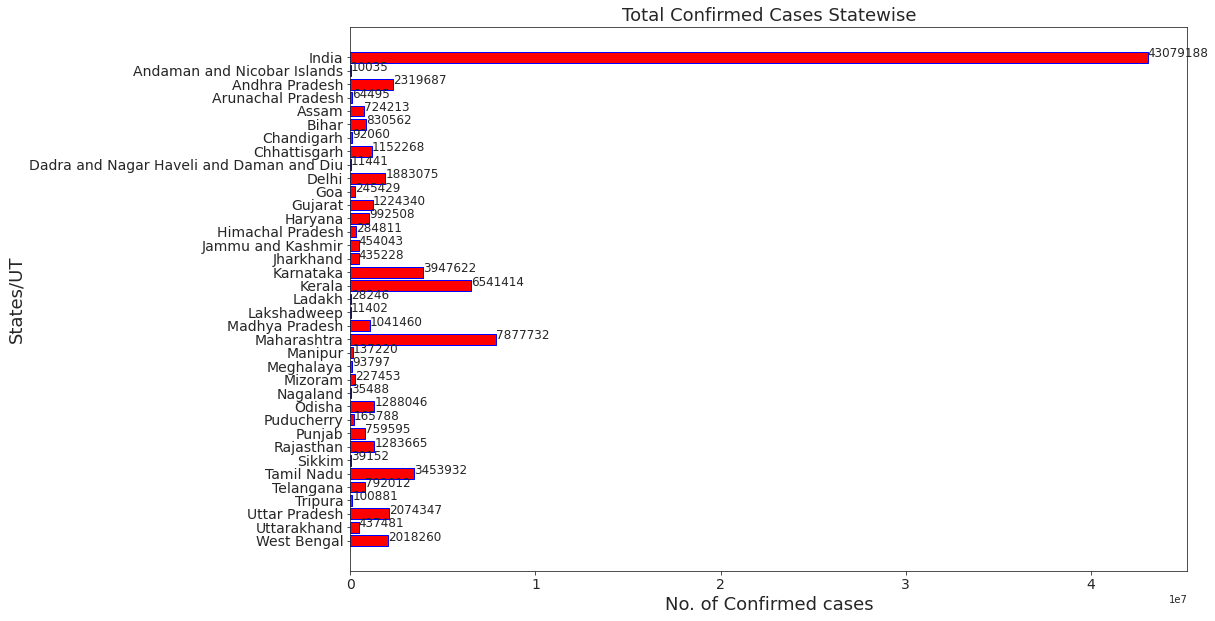

In [37]:
#Bar Chart —Statewise total confirmed cases
sns.set_style("ticks")
plt.figure(figsize = (15,10))

plt.barh(state_data["States/UT"],    
state_data["Confirmed"].map(int),align = 'center', color = 
         'red', edgecolor = 'blue')

plt.xlabel('No. of Confirmed cases', fontsize = 18)
plt.ylabel('States/UT', fontsize = 18)
plt.gca().invert_yaxis()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Total Confirmed Cases Statewise', fontsize = 18 )

for index, value in enumerate(state_data["Confirmed"]):
    plt.text(value, index, str(value), fontsize = 12)

plt.show()

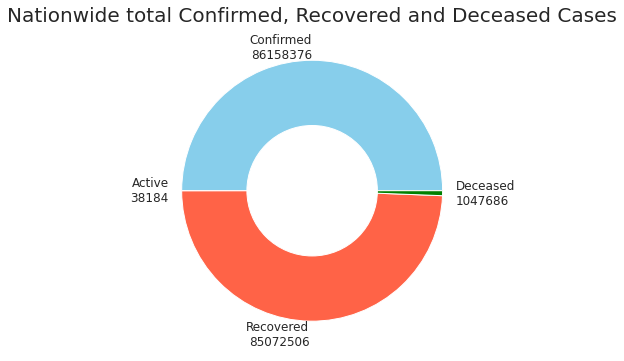

In [41]:
#Donut Chart — Nationwide total Confirmed, Recovered and Deceased cases

group_size = [sum(state_data['Confirmed']),
              sum(state_data['Active']),
              sum(state_data['Recovered']),
              sum(state_data['Deceased'])]
group_labels = ['Confirmed\n' + str(sum(state_data['Confirmed'])),
                'Active\n' + str(sum(state_data['Active'])),
                'Recovered\n' + str(sum(state_data['Recovered'])),
                'Deceased\n' + str(sum(state_data['Deceased']))]

custom_colors = ['skyblue','yellowgreen','tomato', 'green']

plt.figure(figsize = (6,6))
plt.pie(group_size, labels = group_labels, colors = custom_colors)
central_circle = plt.Circle((0,0), 0.5, color = 'white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size = 12)
plt.title('Nationwide total Confirmed, Recovered and Deceased Cases', fontsize = 20)

plt.show()






In [65]:
# reading the shape file of map of India in GeoDataFrame
map_data = gpd.read_file('india-polygon.shp')
map_data.rename(columns = {'st_nm':'States/UT'}, inplace = True)
map_data.head()

,id,States/UT,geometry
0,None,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0..."
1,None,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612..."
2,None,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578..."
3,None,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640..."
4,None,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552..."


In [67]:
#Merge the two dataframes state_data and map_data on States/UT names —
merged_data = pd.merge(map_data, state_data, 
                       how = 'left', on = 'States/UT')
merged_data.fillna(0, inplace = True)
merged_data.drop('Sr.No', axis = 1, inplace = True)
merged_data.head()

,id,States/UT,geometry,Confirmed,Active,Recovered,Deceased
0,0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",10035.0,0.0,9906.0,129.0
1,0,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",64495.0,0.0,64199.0,296.0
2,0,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",724213.0,11.0,716216.0,7986.0
3,0,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",830562.0,40.0,818266.0,12256.0
4,0,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552...",92060.0,71.0,90824.0,1165.0


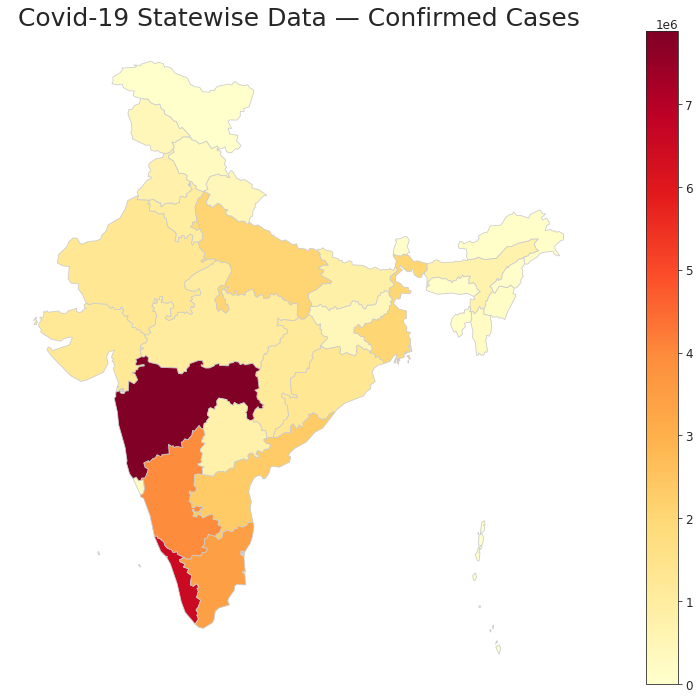

In [70]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Covid-19 Statewise Data — Confirmed Cases', 
             fontdict =  {'fontsize': '25', 'fontweight' : '3'})
merged_data.plot(column = 'Confirmed', cmap='YlOrRd', 
                 linewidth=0.8, ax=ax, edgecolor='0.8', 
                 legend = True)
plt.show()